🎙️ Recording started...
🛑 Recording stopped. Saved as recorded.wav



===== Interview Voice Analysis =====
✅ Confidence: 0.7/10 — Weak confidence, needs significant improvement.
⚖️ Calmness: 5.8/10 — Average calmness, practice needed.
🔊 Clarity: 2.6/10 — Weak clarity, needs significant improvement.
⏱️ Pacing: 8.2/10 (WPM: 195) — Excellent pacing, very professional.
📊 Overall Readiness: 43% — Work needed to improve.


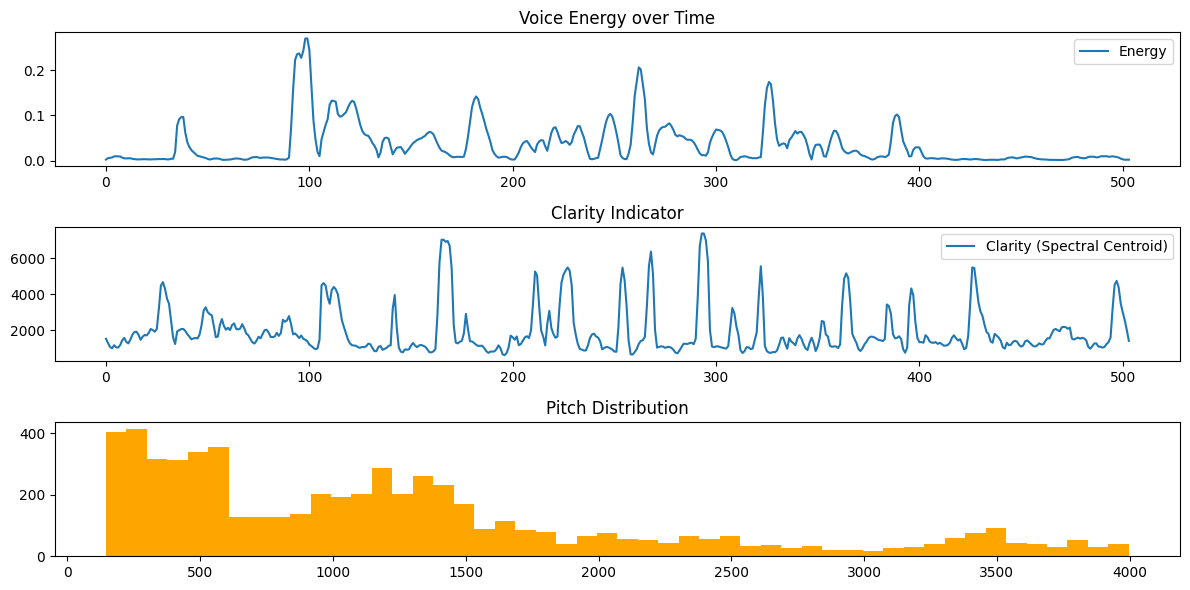

In [4]:
# =========================
# Install Dependencies
# =========================
!pip install librosa soundfile ipywidgets

import librosa, numpy as np, matplotlib.pyplot as plt
import io, warnings
import IPython.display as ipd
from scipy.stats import zscore
from google.colab import output, files
import ipywidgets as widgets

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

AUDIO_FILE = "recorded.wav"

# =========================
# Helper Functions
# =========================
def compute_confidence(pitch, energy):
    stability = 1 - np.std(zscore(pitch))
    energy_norm = np.mean(energy) / np.max(energy)
    score = ((stability + energy_norm) / 2) * 10
    return np.clip(score, 0, 10)

def compute_calmness(pause_ratio, jitter):
    score = (1 - pause_ratio) * (1 - jitter) * 10
    return np.clip(score, 0, 10)

def compute_clarity(spectral_centroid):
    clarity_norm = np.mean(spectral_centroid) / np.max(spectral_centroid)
    return np.clip(clarity_norm * 10, 0, 10)

def compute_pacing(duration, word_count_est):
    wpm = (word_count_est / duration) * 60
    if 120 <= wpm <= 160:
        score = 10
    elif wpm < 120:
        score = max(5, (wpm / 120) * 10)
    else:
        score = max(5, (160 / wpm) * 10)
    return np.clip(score, 0, 10), wpm

def interpret(metric, score):
    if score >= 8:
        return f"Excellent {metric}, very professional."
    elif score >= 6:
        return f"Good {metric}, but can improve slightly."
    elif score >= 4:
        return f"Average {metric}, practice needed."
    else:
        return f"Weak {metric}, needs significant improvement."

# =========================
# Analysis Function
# =========================
def analyze_voice(file):
    y, sr = librosa.load(file)
    duration = librosa.get_duration(y=y, sr=sr)

    # Features
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    pitch = pitch[pitch > 0]
    energy = librosa.feature.rms(y=y)[0]
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # Pause detection
    intervals = librosa.effects.split(y, top_db=30)
    non_silence = sum((end - start) for start, end in intervals)
    pause_ratio = 1 - (non_silence / len(y))

    # Jitter
    pitch_diffs = np.diff(pitch)
    jitter = np.std(pitch_diffs) / np.mean(pitch) if np.mean(pitch) > 0 else 0.05

    # Word count estimate
    word_count_est = len(librosa.onset.onset_detect(y=y, sr=sr))

    # Scores
    confidence = compute_confidence(pitch, energy)
    calmness = compute_calmness(pause_ratio, jitter)
    clarity = compute_clarity(spectral_centroid)
    pacing, wpm = compute_pacing(duration, word_count_est)
    overall = np.mean([confidence, calmness, clarity, pacing]) * 10

    # Results
    print("\n===== Interview Voice Analysis =====")
    print(f"✅ Confidence: {confidence:.1f}/10 — {interpret('confidence', confidence)}")
    print(f"⚖️ Calmness: {calmness:.1f}/10 — {interpret('calmness', calmness)}")
    print(f"🔊 Clarity: {clarity:.1f}/10 — {interpret('clarity', clarity)}")
    print(f"⏱️ Pacing: {pacing:.1f}/10 (WPM: {wpm:.0f}) — {interpret('pacing', pacing)}")
    print(f"📊 Overall Readiness: {overall:.0f}% — {'Ready for interviews!' if overall>70 else 'Work needed to improve.'}")

    # Visuals
    plt.figure(figsize=(12, 6))

    plt.subplot(3,1,1)
    plt.plot(energy, label='Energy')
    plt.title('Voice Energy over Time')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(spectral_centroid, label='Clarity (Spectral Centroid)')
    plt.title('Clarity Indicator')
    plt.legend()

    plt.subplot(3,1,3)
    plt.hist(pitch, bins=50, color='orange')
    plt.title('Pitch Distribution')

    plt.tight_layout()
    plt.show()

    ipd.display(ipd.Audio(file))

# =========================
# Recorder (JS)
# =========================
RECORD_JS = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
var recorder, stream;

async function recordAudio() {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  recorder = new MediaRecorder(stream);
  let data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  window.stopRecording = () => new Promise(resolve => {
    recorder.onstop = () => {
      let blob = new Blob(data, { type: 'audio/wav' });
      let file = new File([blob], 'recorded.wav', { type: 'audio/wav' });
      let reader = new FileReader();
      reader.onload = () => {
        google.colab.kernel.invokeFunction('notebook.record', [Array.from(new Uint8Array(reader.result))], {});
        resolve();
      };
      reader.readAsArrayBuffer(file);
    };
    recorder.stop();
    stream.getTracks().forEach(track => track.stop());
  });
}
"""

# Save recorded audio
def save_audio(data):
    with open(AUDIO_FILE, "wb") as f:
        f.write(bytearray(data))

output.register_callback('notebook.record', save_audio)

# =========================
# Button Actions
# =========================
def start_recording(b):
    output.eval_js(RECORD_JS + "recordAudio()")
    print("🎙️ Recording started...")

def stop_recording(b):
    output.eval_js("stopRecording()")
    print("🛑 Recording stopped. Saved as recorded.wav")

def play_audio(b):
    try:
        display(ipd.Audio(AUDIO_FILE))
    except:
        print("⚠️ No audio recorded yet.")

def analyze_recording(b):
    try:
        analyze_voice(AUDIO_FILE)
    except:
        print("⚠️ No recording found!")

def upload_and_analyze(b):
    uploaded = files.upload()
    for fn in uploaded.keys():
        analyze_voice(fn)

# =========================
# UI
# =========================
start_btn = widgets.Button(description="🎤 Start Recording", button_style="success")
stop_btn = widgets.Button(description="🛑 Stop Recording", button_style="danger")
play_btn = widgets.Button(description="▶️ Play Recording")
analyze_btn = widgets.Button(description="🔎 Analyze Recording")
upload_btn = widgets.Button(description="📂 Upload & Analyze")

start_btn.on_click(start_recording)
stop_btn.on_click(stop_recording)
play_btn.on_click(play_audio)
analyze_btn.on_click(analyze_recording)
upload_btn.on_click(upload_and_analyze)

display(widgets.HBox([start_btn, stop_btn, play_btn]))
display(widgets.HBox([analyze_btn, upload_btn]))
